# Relief Pitcher Dataset Creation

Creates a filtered dataset of MLB relief pitcher appearances from 2021-2024 Statcast data.

## Pipeline
1. Load raw Statcast data (2021-2024)
2. Select 31 relevant columns and rename for clarity
3. Add pitcher names via `pybaseball` lookup
4. **Filter relief pitchers**: Exclude pitchers with 3+ starts per season
5. **Activity thresholds**: Require 20+ games AND 30+ innings pitched per season
6. Save to `data/statcast_relievers_final.parquet`

## Relief Pitcher Definition / Thresholds
- **Starting Pitcher**: Pitcher threw in inning 1
- **Relief pitcher**: < 3 starts in a season (allows occasional openers)
- Applied at pitcher-year level (2021 appearances filtered separately from 2022, etc.)
- **≥20 games** per season: Excludes emergency/position player pitchers
- **≥30 innings** per season: Ensures sufficient data for analysis

## Final Dataset
- **~650,000 pitches** across 2021-2024
- **~800 unique pitchers**
- **~11,000 game appearances**
- **31 variables**: pitcher ID/name, date, velocity, spin rate, pitch outcomes, game context, rest days

# Data Management

This notebook imports general data management packages and loads the four Statcast Parquet files for the 2021–2024 MLB seasons.

In [198]:
# Import general data management packages
import polars as pl
import numpy as np

In [199]:
# Load all four years of Statcast pitch-level data from Parquet files
statcast_2021 = pl.read_parquet('data/statcast_2021.parquet')
statcast_2022 = pl.read_parquet('data/statcast_2022.parquet')
statcast_2023 = pl.read_parquet('data/statcast_2023.parquet')
statcast_2024 = pl.read_parquet('data/statcast_2024.parquet')

In [200]:
# Calculate total rows and columns across all years for verification
total_rows = (statcast_2021.shape[0] + statcast_2022.shape[0] + 
              statcast_2023.shape[0] + statcast_2024.shape[0])
total_cols = statcast_2021.shape[1]

(total_rows, total_cols)

(2853845, 119)

## Finding Variables
### We know they have the exact same columns from last notebooks exploration. Part 1 is gaining knowledge on what variables we need to keep to run analysis

In [201]:
# Display column schema to see all available variables
statcast_2021.schema

Schema([('pitch_type', String),
        ('game_date', Datetime(time_unit='ns', time_zone=None)),
        ('release_speed', Float64),
        ('release_pos_x', Float64),
        ('release_pos_z', Float64),
        ('player_name', String),
        ('batter', Int64),
        ('pitcher', Int64),
        ('events', String),
        ('description', String),
        ('spin_dir', Int64),
        ('spin_rate_deprecated', Int64),
        ('break_angle_deprecated', Int64),
        ('break_length_deprecated', Int64),
        ('zone', Int64),
        ('des', String),
        ('game_type', String),
        ('stand', String),
        ('p_throws', String),
        ('home_team', String),
        ('away_team', String),
        ('type', String),
        ('hit_location', Int64),
        ('bb_type', String),
        ('balls', Int64),
        ('strikes', Int64),
        ('game_year', Int64),
        ('pfx_x', Float64),
        ('pfx_z', Float64),
        ('plate_x', Float64),
        ('plate_z', Float64),
 

In [202]:
# Define list of 31 columns needed for relief pitcher rest day analysis
# Includes: pitcher ID, dates, velocity/spin metrics, pitch outcomes, game context
relevant_columns = [
    # Pitcher identification
    'pitcher',
    
    # Date/time for calculating rest days
    'game_date', 'game_pk',
    
    # Pitch characteristics (velocity and spin rate - primary metrics)
    'release_speed', 'release_spin_rate', 'pitch_type', 'pitch_name',
    
    # Pitch outcomes for strike percentage and control metrics
    'description', 'events', 'type', 'zone',
    
    # Count information for control analysis
    'balls', 'strikes', 'outs_when_up',
    
    # Game context
    'inning', 'inning_topbot', 'home_team', 'away_team',
    'at_bat_number', 'pitch_number',
    
    # Additional outcome metrics (for walks and ERA calculations)
    'bb_type', 'on_1b', 'on_2b', 'on_3b',
    
    # Runs data for ERA calculation
    'post_away_score', 'post_home_score', 'fld_score', 'bat_score',
    
    # For identifying relief pitchers and game situation
    'game_type', 'stand', 'p_throws',
    'pitcher_days_since_prev_game', 'pitcher_days_until_next_game'
]

In [203]:
# Filter each year to only the 31 relevant columns (reduces memory usage)
statcast_2021_filtered = statcast_2021.select(relevant_columns)
statcast_2022_filtered = statcast_2022.select(relevant_columns)
statcast_2023_filtered = statcast_2023.select(relevant_columns)
statcast_2024_filtered = statcast_2024.select(relevant_columns)

In [204]:
# Preview filtered 2021 data to verify column selection
statcast_2021_filtered.head()

pitcher,game_date,game_pk,release_speed,release_spin_rate,pitch_type,pitch_name,description,events,type,zone,balls,strikes,outs_when_up,inning,inning_topbot,home_team,away_team,at_bat_number,pitch_number,bb_type,on_1b,on_2b,on_3b,post_away_score,post_home_score,fld_score,bat_score,game_type,stand,p_throws,pitcher_days_since_prev_game,pitcher_days_until_next_game
i64,datetime[ns],i64,f64,i64,str,str,str,str,str,i64,i64,i64,i64,i64,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64
519293,2021-10-03 00:00:00,632254,92.3,2330,"""FF""","""4-Seam Fastball""","""hit_into_play""","""field_out""","""X""",1,1,2,2,9,"""Top""","""ATL""","""NYM""",61,4,"""ground_ball""",null,null,null,0,5,5,0,"""R""","""R""","""L""",3,6
519293,2021-10-03 00:00:00,632254,80.6,2254,"""SL""","""Slider""","""foul""",null,"""S""",4,1,1,2,9,"""Top""","""ATL""","""NYM""",61,3,null,null,null,null,0,5,5,0,"""R""","""R""","""L""",3,6
519293,2021-10-03 00:00:00,632254,75.5,1940,"""CU""","""Curveball""","""foul""",null,"""S""",5,1,0,2,9,"""Top""","""ATL""","""NYM""",61,2,null,null,null,null,0,5,5,0,"""R""","""R""","""L""",3,6
519293,2021-10-03 00:00:00,632254,75.0,2017,"""CU""","""Curveball""","""ball""",null,"""B""",12,0,0,2,9,"""Top""","""ATL""","""NYM""",61,1,null,null,null,null,0,5,5,0,"""R""","""R""","""L""",3,6
519293,2021-10-03 00:00:00,632254,91.2,2281,"""FF""","""4-Seam Fastball""","""hit_into_play""","""field_out""","""X""",4,1,0,1,9,"""Top""","""ATL""","""NYM""",60,2,"""ground_ball""",null,null,null,0,5,5,0,"""R""","""L""","""L""",3,6


In [205]:
# Define mapping to rename columns to more intuitive names
# Examples: 'pitcher' -> 'pitcher_id', 'release_speed' -> 'velocity'
column_rename_map = {
    'pitcher': 'pitcher_id',
    'game_date': 'date',
    'game_pk': 'game_id',
    'release_speed': 'velocity',
    'release_spin_rate': 'spin_rate',
    'pitch_type': 'pitch_type_abbr',
    'pitch_name': 'pitch_type',
    'description': 'pitch_result',
    'events': 'ab_result',
    'type': 'pitch_call',
    'zone': 'strike_zone',
    'balls': 'ball_count',
    'strikes': 'strike_count',
    'outs_when_up': 'outs',
    'inning_topbot': 'top_bottom',
    'at_bat_number': 'ab_number',
    'pitch_number': 'pitch_num',
    'bb_type': 'batted_ball_type',
    'on_1b': 'runner_1b',
    'on_2b': 'runner_2b',
    'on_3b': 'runner_3b',
    'post_away_score': 'away_score',
    'post_home_score': 'home_score',
    'fld_score': 'defense_score',
    'bat_score': 'offense_score',
    'stand': 'batter_side',
    'p_throws': 'pitcher_hand'
}

In [206]:
# Apply column renaming to all four years
statcast_2021_filtered = statcast_2021_filtered.rename(column_rename_map)
statcast_2022_filtered = statcast_2022_filtered.rename(column_rename_map)
statcast_2023_filtered = statcast_2023_filtered.rename(column_rename_map)
statcast_2024_filtered = statcast_2024_filtered.rename(column_rename_map)

In [207]:
# Verify renamed columns
statcast_2021_filtered.head()

pitcher_id,date,game_id,velocity,spin_rate,pitch_type_abbr,pitch_type,pitch_result,ab_result,pitch_call,strike_zone,ball_count,strike_count,outs,inning,top_bottom,home_team,away_team,ab_number,pitch_num,batted_ball_type,runner_1b,runner_2b,runner_3b,away_score,home_score,defense_score,offense_score,game_type,batter_side,pitcher_hand,pitcher_days_since_prev_game,pitcher_days_until_next_game
i64,datetime[ns],i64,f64,i64,str,str,str,str,str,i64,i64,i64,i64,i64,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64
519293,2021-10-03 00:00:00,632254,92.3,2330,"""FF""","""4-Seam Fastball""","""hit_into_play""","""field_out""","""X""",1,1,2,2,9,"""Top""","""ATL""","""NYM""",61,4,"""ground_ball""",null,null,null,0,5,5,0,"""R""","""R""","""L""",3,6
519293,2021-10-03 00:00:00,632254,80.6,2254,"""SL""","""Slider""","""foul""",null,"""S""",4,1,1,2,9,"""Top""","""ATL""","""NYM""",61,3,null,null,null,null,0,5,5,0,"""R""","""R""","""L""",3,6
519293,2021-10-03 00:00:00,632254,75.5,1940,"""CU""","""Curveball""","""foul""",null,"""S""",5,1,0,2,9,"""Top""","""ATL""","""NYM""",61,2,null,null,null,null,0,5,5,0,"""R""","""R""","""L""",3,6
519293,2021-10-03 00:00:00,632254,75.0,2017,"""CU""","""Curveball""","""ball""",null,"""B""",12,0,0,2,9,"""Top""","""ATL""","""NYM""",61,1,null,null,null,null,0,5,5,0,"""R""","""R""","""L""",3,6
519293,2021-10-03 00:00:00,632254,91.2,2281,"""FF""","""4-Seam Fastball""","""hit_into_play""","""field_out""","""X""",4,1,0,1,9,"""Top""","""ATL""","""NYM""",60,2,"""ground_ball""",null,null,null,0,5,5,0,"""R""","""L""","""L""",3,6


In [208]:
# Add year column to each dataset for tracking season
statcast_2021_filtered = statcast_2021_filtered.with_columns(pl.lit(2021).alias('year'))
statcast_2022_filtered = statcast_2022_filtered.with_columns(pl.lit(2022).alias('year'))
statcast_2023_filtered = statcast_2023_filtered.with_columns(pl.lit(2023).alias('year'))
statcast_2024_filtered = statcast_2024_filtered.with_columns(pl.lit(2024).alias('year'))

In [209]:
# Combine all four years into single dataset and sort by pitcher, date, game, and pitch number
(statcast_combined := pl.concat([
    statcast_2021_filtered,
    statcast_2022_filtered,
    statcast_2023_filtered,
    statcast_2024_filtered
]).sort(['pitcher_id', 'date', 'game_id', 'pitch_num']))

pitcher_id,date,game_id,velocity,spin_rate,pitch_type_abbr,pitch_type,pitch_result,ab_result,pitch_call,strike_zone,ball_count,strike_count,outs,inning,top_bottom,home_team,away_team,ab_number,pitch_num,batted_ball_type,runner_1b,runner_2b,runner_3b,away_score,home_score,defense_score,offense_score,game_type,batter_side,pitcher_hand,pitcher_days_since_prev_game,pitcher_days_until_next_game,year
i64,datetime[ns],i64,f64,i64,str,str,str,str,str,i64,i64,i64,i64,i64,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,i32
405395,2022-05-15 00:00:00,661984,63.7,1695,"""FA""","""Other""","""ball""",null,"""B""",12,0,0,0,9,"""Top""","""STL""","""SF""",79,1,null,null,null,null,2,15,15,2,"""R""","""R""","""R""",null,null,2022
405395,2022-05-15 00:00:00,661984,64.4,1571,"""FA""","""Other""","""foul""",null,"""S""",1,0,0,2,9,"""Top""","""STL""","""SF""",85,1,null,null,null,null,6,15,15,6,"""R""","""L""","""R""",null,null,2022
405395,2022-05-15 00:00:00,661984,63.5,1699,"""FA""","""Other""","""ball""",null,"""B""",12,0,0,0,9,"""Top""","""STL""","""SF""",80,1,null,573131,null,null,2,15,15,2,"""R""","""R""","""R""",null,null,2022
405395,2022-05-15 00:00:00,661984,53.6,1450,"""FA""","""Other""","""ball""",null,"""B""",13,0,0,2,9,"""Top""","""STL""","""SF""",84,1,null,null,null,null,5,15,15,5,"""R""","""R""","""R""",null,null,2022
405395,2022-05-15 00:00:00,661984,54.0,1485,"""FA""","""Other""","""called_strike""",null,"""S""",4,0,0,1,9,"""Top""","""STL""","""SF""",81,1,null,573131,null,null,2,15,15,2,"""R""","""R""","""R""",null,null,2022
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
814005,2024-07-23 00:00:00,745632,82.9,2333,"""ST""","""Sweeper""","""ball""",null,"""B""",14,2,2,2,3,"""Bot""","""ATH""","""HOU""",25,6,null,null,667670,null,1,3,1,3,"""R""","""R""","""R""",12,null,2024
814005,2024-07-23 00:00:00,745632,90.6,2324,"""FF""","""4-Seam Fastball""","""hit_into_play""","""home_run""","""X""",6,3,2,1,4,"""Bot""","""ATH""","""HOU""",31,6,"""fly_ball""",null,null,null,1,5,1,4,"""R""","""R""","""R""",12,null,2024
814005,2024-07-23 00:00:00,745632,81.5,2452,"""ST""","""Sweeper""","""ball""","""walk""","""B""",14,3,2,2,3,"""Bot""","""ATH""","""HOU""",24,6,null,null,null,null,1,3,1,3,"""R""","""R""","""R""",12,null,2024


## Adding Pitcher Names

In [210]:
# Import pybaseball for looking up pitcher names from IDs
import pybaseball as pyb
import pandas as pd

In [211]:
# Extract unique pitcher IDs to look up names
unique_pitcher_ids = statcast_combined['pitcher_id'].unique().to_list()

In [212]:
# Use pybaseball to get pitcher names from MLBAM IDs (returns pandas DataFrame)
pitcher_names_df = pyb.playerid_reverse_lookup(unique_pitcher_ids, key_type='mlbam')

In [213]:
# Convert to Polars, select columns, and create full name with title case
pitcher_names = (
    pl.from_pandas(pitcher_names_df)
    .select([
        pl.col('key_mlbam').alias('pitcher_id'),
        pl.col('name_first').alias('first_name'),
        pl.col('name_last').alias('last_name')
    ])
    .with_columns(
        (pl.col('first_name').str.to_titlecase() + ' ' + 
         pl.col('last_name').str.to_titlecase()).alias('pitcher_name')
    )
)

In [214]:
# Preview pitcher name lookup table
pitcher_names.head()

pitcher_id,first_name,last_name,pitcher_name
i64,str,str,str
594987,"""casey""","""sadler""","""Casey Sadler"""
680911,"""owen""","""miller""","""Owen Miller"""
703231,"""james""","""meeker""","""James Meeker"""
660636,"""diego""","""castillo""","""Diego Castillo"""
570666,"""luis""","""cessa""","""Luis Cessa"""


In [215]:
# Join pitcher names to main dataset using pitcher_id
statcast_combined = statcast_combined.join(
    pitcher_names.select(['pitcher_id', 'pitcher_name']),
    on='pitcher_id',
    how='left'
)

In [216]:
# Preview final combined dataset with pitcher names
statcast_combined.head()

pitcher_id,date,game_id,velocity,spin_rate,pitch_type_abbr,pitch_type,pitch_result,ab_result,pitch_call,strike_zone,ball_count,strike_count,outs,inning,top_bottom,home_team,away_team,ab_number,pitch_num,batted_ball_type,runner_1b,runner_2b,runner_3b,away_score,home_score,defense_score,offense_score,game_type,batter_side,pitcher_hand,pitcher_days_since_prev_game,pitcher_days_until_next_game,year,pitcher_name
i64,datetime[ns],i64,f64,i64,str,str,str,str,str,i64,i64,i64,i64,i64,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,i32,str
405395,2022-05-15 00:00:00,661984,63.7,1695,"""FA""","""Other""","""ball""",null,"""B""",12,0,0,0,9,"""Top""","""STL""","""SF""",79,1,null,null,null,null,2,15,15,2,"""R""","""R""","""R""",null,null,2022,"""Albert Pujols"""
405395,2022-05-15 00:00:00,661984,64.4,1571,"""FA""","""Other""","""foul""",null,"""S""",1,0,0,2,9,"""Top""","""STL""","""SF""",85,1,null,null,null,null,6,15,15,6,"""R""","""L""","""R""",null,null,2022,"""Albert Pujols"""
405395,2022-05-15 00:00:00,661984,63.5,1699,"""FA""","""Other""","""ball""",null,"""B""",12,0,0,0,9,"""Top""","""STL""","""SF""",80,1,null,573131,null,null,2,15,15,2,"""R""","""R""","""R""",null,null,2022,"""Albert Pujols"""
405395,2022-05-15 00:00:00,661984,53.6,1450,"""FA""","""Other""","""ball""",null,"""B""",13,0,0,2,9,"""Top""","""STL""","""SF""",84,1,null,null,null,null,5,15,15,5,"""R""","""R""","""R""",null,null,2022,"""Albert Pujols"""
405395,2022-05-15 00:00:00,661984,54.0,1485,"""FA""","""Other""","""called_strike""",null,"""S""",4,0,0,1,9,"""Top""","""STL""","""SF""",81,1,null,573131,null,null,2,15,15,2,"""R""","""R""","""R""",null,null,2022,"""Albert Pujols"""


## Filtering for Relief Pitchers

We identify pitchers who started 3+ games in a season, then filter them out.

In [217]:
# Step 1: Count how many games each pitcher started (appeared in inning 1) per year
(starts_per_year := (statcast_combined
    .filter(pl.col('inning') == 1)
    .group_by(['pitcher_id', 'year', 'pitcher_name', 'game_id'])
    .agg(pl.len().alias('pitches'))  # Just need to confirm they pitched in inning 1
    .group_by(['pitcher_id', 'year', 'pitcher_name'])
    .agg(pl.len().alias('starts'))
    .sort('starts', descending=True)
))

pitcher_id,year,pitcher_name,starts
i64,i32,str,u32
571945,2023,"""Miles Mikolas""",35
668678,2023,"""Zac Gallen""",34
656302,2024,"""Dylan Cease""",33
656302,2023,"""Dylan Cease""",33
676710,2024,"""Kutter Crawford""",33
…,…,…,…
608718,2021,"""Brent Suter""",1
676617,2021,"""Riley O'Brien""",1
488984,2021,"""Tommy Hunter""",1


In [218]:
# Step 2: Filter to relief pitchers (those with LESS THAN 3 starts per season)
# First, get pitcher-years with 3+ starts (these will be excluded)
frequent_starters = starts_per_year.filter(pl.col('starts') >= 3).select(['pitcher_id', 'year'])

# Then exclude those pitcher-years from the main dataset
(statcast_relievers := statcast_combined.join(
    frequent_starters,
    on=['pitcher_id', 'year'],
    how='anti'  # Keep only pitcher-years NOT in frequent_starters
))

print(f"Original dataset: {statcast_combined.shape[0]} pitches")
print(f"Relief pitcher dataset: {statcast_relievers.shape[0]} pitches")
print(f"Pitches removed: {statcast_combined.shape[0] - statcast_relievers.shape[0]}")

Original dataset: 2853845 pitches
Relief pitcher dataset: 1048746 pitches
Pitches removed: 1805099


## Analyzing Pitcher Activity Distribution

Before filtering, let's examine the distribution of pitcher activity to set a data-driven threshold for minimum games pitched.

In [219]:
# Calculate total games pitched per pitcher per year
# Note: This counts unique games, not total appearances (a pitcher could appear multiple times per day)
(pitcher_games_per_year := (statcast_relievers
    .group_by(['pitcher_id', 'year', 'pitcher_name'])
    .agg(pl.col('game_id').n_unique().alias('games_pitched'))
    .sort('games_pitched', descending=True)
))

pitcher_id,year,pitcher_name,games_pitched
i64,i32,str,u32
543766,2021,"""Bryan Shaw""",81
643511,2021,"""Tyler Rogers""",80
519008,2024,"""T. J. Mcfarland""",79
666374,2023,"""Matt Brash""",78
433589,2021,"""Yusmeiro Petit""",78
…,…,…,…
622268,2024,"""Donovan Walton""",1
593140,2022,"""Michael Feliz""",1
645801,2022,"""Mike Ford""",1


In [220]:
# Get summary statistics for games pitched distribution
pitcher_games_per_year.select([
    pl.col('games_pitched').min().alias('min'),
    pl.col('games_pitched').quantile(0.25).alias('25th_percentile'),
    pl.col('games_pitched').median().alias('median'),
    pl.col('games_pitched').quantile(0.75).alias('75th_percentile'),
    pl.col('games_pitched').quantile(0.90).alias('90th_percentile'),
    pl.col('games_pitched').max().alias('max'),
    pl.col('games_pitched').mean().alias('mean')
])

min,25th_percentile,median,75th_percentile,90th_percentile,max,mean
u32,f64,f64,f64,f64,u32,f64
1,3.0,14.0,45.0,63.0,81,24.539407


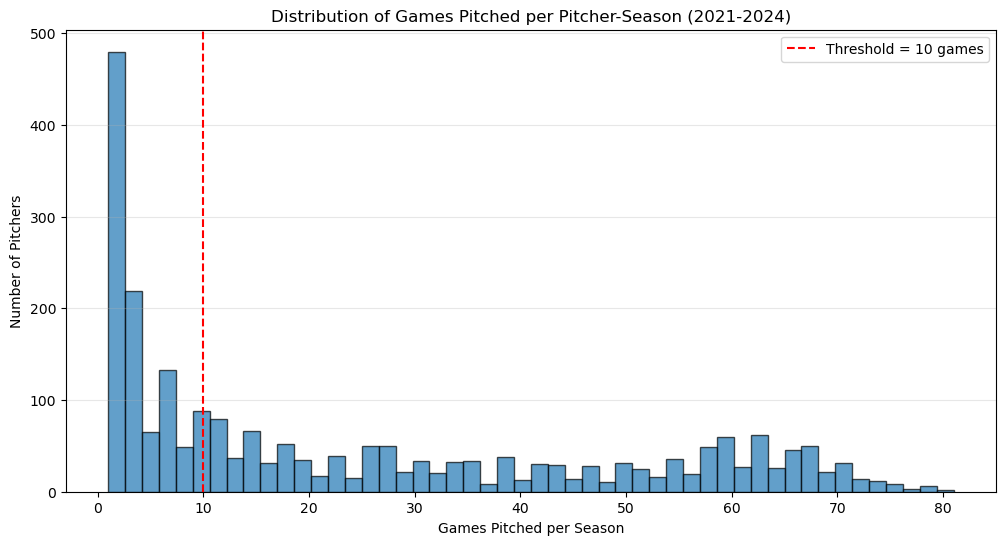

In [221]:
# Create histogram using matplotlib to visualize distribution
import matplotlib.pyplot as plt

games_pitched_list = pitcher_games_per_year['games_pitched'].to_list()

plt.figure(figsize=(12, 6))
plt.hist(games_pitched_list, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Games Pitched per Season')
plt.ylabel('Number of Pitchers')
plt.title('Distribution of Games Pitched per Pitcher-Season (2021-2024)')
plt.axvline(10, color='red', linestyle='--', label='Threshold = 10 games')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [222]:
# Count how many pitcher-seasons would be excluded at different thresholds
thresholds = [5, 10, 15, 20, 25, 30]

for threshold in thresholds:
    count = pitcher_games_per_year.filter(pl.col('games_pitched') >= threshold).shape[0]
    total = pitcher_games_per_year.shape[0]
    pct = (count / total) * 100
    print(f"Threshold >= {threshold:2d} games: {count:4d} pitcher-seasons ({pct:.1f}% retained)")

Threshold >=  5 games: 1661 pitcher-seasons (70.4% retained)
Threshold >= 10 games: 1368 pitcher-seasons (58.0% retained)
Threshold >= 15 games: 1172 pitcher-seasons (49.7% retained)
Threshold >= 20 games: 1044 pitcher-seasons (44.2% retained)
Threshold >= 25 games:  955 pitcher-seasons (40.5% retained)
Threshold >= 30 games:  833 pitcher-seasons (35.3% retained)


I am going with players who appeared in more than 20 games. The next and final criteria will be innings pitched

In [223]:
(year_pitchers := pitcher_games_per_year.filter(pl.col('games_pitched') >= 20))

pitcher_id,year,pitcher_name,games_pitched
i64,i32,str,u32
543766,2021,"""Bryan Shaw""",81
643511,2021,"""Tyler Rogers""",80
519008,2024,"""T. J. Mcfarland""",79
666374,2023,"""Matt Brash""",78
433589,2021,"""Yusmeiro Petit""",78
…,…,…,…
657770,2022,"""Eric Stout""",20
670102,2023,"""Bowden Francis""",20
608652,2021,"""Luke Farrell""",20


In [224]:
# Get unique pitcher IDs from year_pitchers (pitchers with 20+ games in a season)
unique_pitcher_ids_20plus = year_pitchers['pitcher_id'].unique().sort()

print(f"Number of unique pitchers with 20+ games in at least one season: {len(unique_pitcher_ids_20plus)}")
unique_pitcher_ids_20plus

Number of unique pitchers with 20+ games in at least one season: 547


pitcher_id
i64
433589
445213
445276
445926
446321
…
694037
695243
700187


In [225]:
# Filter statcast_relievers to only include pitchers who appeared in 20+ games in a season
statcast_relievers_year_filtered = statcast_relievers.join(
    year_pitchers.select(['pitcher_id', 'year']),
    on=['pitcher_id', 'year'],
    how='inner'
)

# Verify the filtering worked
print(f"Original shape: {statcast_relievers.shape}")
print(f"Filtered shape: {statcast_relievers_year_filtered.shape}")
print(f"Pitches removed: {statcast_relievers.shape[0] - statcast_relievers_year_filtered.shape[0]}")

# Show sample of filtered data
statcast_relievers_year_filtered.head()

Original shape: (1048746, 35)
Filtered shape: (856709, 35)
Pitches removed: 192037


pitcher_id,date,game_id,velocity,spin_rate,pitch_type_abbr,pitch_type,pitch_result,ab_result,pitch_call,strike_zone,ball_count,strike_count,outs,inning,top_bottom,home_team,away_team,ab_number,pitch_num,batted_ball_type,runner_1b,runner_2b,runner_3b,away_score,home_score,defense_score,offense_score,game_type,batter_side,pitcher_hand,pitcher_days_since_prev_game,pitcher_days_until_next_game,year,pitcher_name
i64,datetime[ns],i64,f64,i64,str,str,str,str,str,i64,i64,i64,i64,i64,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,i32,str
433589,2021-04-01 00:00:00,634640,85.8,1989,"""FF""","""4-Seam Fastball""","""ball""",null,"""B""",11,0,0,2,6,"""Top""","""ATH""","""HOU""",41,1,null,null,670541,null,3,0,0,3,"""R""","""R""","""R""",null,3,2021,"""Yusmeiro Petit"""
433589,2021-04-01 00:00:00,634640,87.5,2182,"""FF""","""4-Seam Fastball""","""ball""",null,"""B""",12,0,0,1,6,"""Top""","""ATH""","""HOU""",39,1,null,663656,608324,null,1,0,0,1,"""R""","""R""","""R""",null,3,2021,"""Yusmeiro Petit"""
433589,2021-04-01 00:00:00,634640,85.6,2136,"""FF""","""4-Seam Fastball""","""ball""",null,"""B""",11,0,0,2,6,"""Top""","""ATH""","""HOU""",40,1,null,663656,608324,null,1,0,0,1,"""R""","""L""","""R""",null,3,2021,"""Yusmeiro Petit"""
433589,2021-04-01 00:00:00,634640,72.4,1772,"""CU""","""Curveball""","""called_strike""",null,"""S""",5,1,0,2,6,"""Top""","""ATH""","""HOU""",41,2,null,null,670541,null,3,0,0,3,"""R""","""R""","""R""",null,3,2021,"""Yusmeiro Petit"""
433589,2021-04-01 00:00:00,634640,87.2,2153,"""FF""","""4-Seam Fastball""","""ball""",null,"""B""",14,1,0,1,6,"""Top""","""ATH""","""HOU""",39,2,null,663656,608324,null,1,0,0,1,"""R""","""R""","""R""",null,3,2021,"""Yusmeiro Petit"""


In [226]:
# Get unique pitcher IDs from the filtered dataset (20+ games filter)
unique_pitcher_ids_filtered = statcast_relievers_year_filtered['pitcher_id'].unique().sort()

print(f"Number of unique pitchers in filtered dataset: {len(unique_pitcher_ids_filtered)}")
unique_pitcher_ids_filtered

Number of unique pitchers in filtered dataset: 547


pitcher_id
i64
433589
445213
445276
445926
446321
…
694037
695243
700187


## Fetching Aggregated Pitching Stats from Baseball Reference

Using pybaseball to get season-level pitching statistics for 2021-2024.

In [227]:
# Fetch aggregated pitching stats for each season from Baseball Reference
pitching_2021 = pyb.pitching_stats(2021, qual=1)  # qual=1 means at least 1 IP
pitching_2022 = pyb.pitching_stats(2022, qual=1)
pitching_2023 = pyb.pitching_stats(2023, qual=1)
pitching_2024 = pyb.pitching_stats(2024, qual=1)

In [228]:
# Add year column to each dataset
pitching_2021['year'] = 2021
pitching_2022['year'] = 2022
pitching_2023['year'] = 2023
pitching_2024['year'] = 2024

In [229]:
# Combine all years into single pandas DataFrame
pitching_stats_combined = pd.concat([pitching_2021, pitching_2022, pitching_2023, pitching_2024], ignore_index=True)

print(f"Total pitcher-seasons: {pitching_stats_combined.shape[0]}")
print(f"Number of columns: {pitching_stats_combined.shape[1]}")
pitching_stats_combined.head()

Total pitcher-seasons: 3437
Number of columns: 394


,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,...,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO,year
0,19361,2021,Corbin Burnes,MIL,26,11,5,7.5,2.43,28,...,NaN,NaN,NaN,132,99,128,NaN,NaN,NaN,2021
1,10310,2021,Zack Wheeler,PHI,31,14,10,7.2,2.78,32,...,NaN,NaN,NaN,119,103,121,NaN,NaN,NaN,2021
2,9132,2021,Nathan Eovaldi,BOS,31,11,9,5.7,3.75,32,...,125.0,88.0,108.0,109,107,114,NaN,NaN,NaN,2021
3,19374,2021,Walker Buehler,LAD,26,16,4,5.6,2.47,33,...,NaN,NaN,NaN,112,100,111,NaN,NaN,NaN,2021
4,3137,2021,Max Scherzer,- - -,36,15,4,5.4,2.46,30,...,NaN,NaN,NaN,111,100,110,NaN,NaN,NaN,2021


In [230]:
# Convert to Polars for consistency with rest of project
pitching_stats_pl = pl.from_pandas(pitching_stats_combined)

# Preview available columns
pitching_stats_pl.head()

IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,GS,CG,ShO,SV,BS,IP,TBF,H,R,ER,HR,BB,IBB,HBP,WP,BK,SO,GB,FB,LD,IFFB,Balls,Strikes,Pitches,RS,IFH,BU,…,botStf FS,botCmd FS,botOvr,botStf,botCmd,botxRV100,Stf+ CH,Loc+ CH,Pit+ CH,Stf+ CU,Loc+ CU,Pit+ CU,Stf+ FA,Loc+ FA,Pit+ FA,Stf+ SI,Loc+ SI,Pit+ SI,Stf+ SL,Loc+ SL,Pit+ SL,Stf+ KC,Loc+ KC,Pit+ KC,Stf+ FC,Loc+ FC,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO,year
i64,i64,str,str,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,i64
19361,2021,"""Corbin Burnes""","""MIL""",26,11,5,7.5,2.43,28,28,0,0,0,0,167.0,657,123,47,45,7,34,0,6,5,0,234,185,115,79,9,872,1722,2594,85,17,4,…,null,null,66.0,66.0,46.0,-0.86,96.0,98.0,94.0,142.0,88.0,119.0,109.0,122.0,118.0,90.0,112.0,96.0,137.0,108.0,140.0,null,null,null,134.0,102.0,140.0,null,null,null,132,99,128,null,null,null,2021
10310,2021,"""Zack Wheeler""","""PHI""",31,14,10,7.2,2.78,32,32,3,2,0,0,213.1,849,169,72,66,16,46,1,8,6,0,247,268,148,122,19,1041,2164,3205,87,11,10,…,65.0,80.0,70.0,64.0,64.0,-1.12,80.0,106.0,87.0,118.0,96.0,107.0,123.0,104.0,122.0,133.0,104.0,140.0,null,null,null,null,null,null,110.0,105.0,115.0,null,null,null,119,103,121,null,null,null,2021
9132,2021,"""Nathan Eovaldi""","""BOS""",31,11,9,5.7,3.75,32,32,0,0,0,0,182.1,764,182,81,76,15,35,2,7,6,0,195,220,182,122,21,908,2019,2927,118,21,3,…,59.0,52.0,67.0,52.0,67.0,-0.9,null,null,null,111.0,102.0,106.0,105.0,109.0,112.0,null,null,null,112.0,110.0,121.0,null,null,null,104.0,121.0,130.0,125.0,88.0,108.0,109,107,114,null,null,null,2021
19374,2021,"""Walker Buehler""","""LAD""",26,16,4,5.6,2.47,33,33,0,0,0,0,207.2,815,149,61,57,19,52,2,6,5,0,212,238,189,106,22,1032,2120,3152,123,13,12,…,null,null,63.0,59.0,59.0,-0.7,98.0,106.0,99.0,null,null,null,111.0,98.0,108.0,95.0,102.0,101.0,133.0,104.0,129.0,110.0,90.0,94.0,109.0,109.0,126.0,null,null,null,112,100,111,null,null,null,2021
3137,2021,"""Max Scherzer""","""- - -""",36,15,4,5.4,2.46,30,30,1,0,0,0,179.1,693,119,53,49,23,36,0,10,2,0,236,136,196,74,19,950,1871,2821,106,12,5,…,null,null,60.0,59.0,58.0,-0.44,99.0,101.0,94.0,104.0,102.0,105.0,114.0,97.0,111.0,null,null,null,120.0,108.0,125.0,null,null,null,105.0,96.0,99.0,null,null,null,111,100,110,null,null,null,2021


In [231]:
# Create a unique pitcher-name-year combination from statcast_relievers_year_filtered
filtered_pitchers = (statcast_relievers_year_filtered
    .select(['pitcher_name', 'year'])
    .unique()
)

print(f"Unique pitcher-year combinations in filtered dataset: {filtered_pitchers.shape[0]}")
filtered_pitchers.head()

Unique pitcher-year combinations in filtered dataset: 1044


pitcher_name,year
str,i32
"""Casey Sadler""",2021
"""Dylan Floro""",2023
"""Alex Vesia""",2021
"""Adrián Martinez""",2023
"""Juan Minaya""",2021


In [232]:
# Filter pitching_stats_pl to only include pitchers from filtered dataset
# Join on both Name and year columns
pitching_stats_filtered = pitching_stats_pl.join(
    filtered_pitchers,
    left_on=['Name', 'year'],
    right_on=['pitcher_name', 'year'],
    how='inner'
)

print(f"Original pitching stats: {pitching_stats_pl.shape[0]} pitcher-seasons")
print(f"Filtered pitching stats: {pitching_stats_filtered.shape[0]} pitcher-seasons")
print(f"Pitcher-seasons removed: {pitching_stats_pl.shape[0] - pitching_stats_filtered.shape[0]}")

pitching_stats_filtered.head()

Original pitching stats: 3437 pitcher-seasons
Filtered pitching stats: 867 pitcher-seasons
Pitcher-seasons removed: 2570


IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,GS,CG,ShO,SV,BS,IP,TBF,H,R,ER,HR,BB,IBB,HBP,WP,BK,SO,GB,FB,LD,IFFB,Balls,Strikes,Pitches,RS,IFH,BU,…,botStf FS,botCmd FS,botOvr,botStf,botCmd,botxRV100,Stf+ CH,Loc+ CH,Pit+ CH,Stf+ CU,Loc+ CU,Pit+ CU,Stf+ FA,Loc+ FA,Pit+ FA,Stf+ SI,Loc+ SI,Pit+ SI,Stf+ SL,Loc+ SL,Pit+ SL,Stf+ KC,Loc+ KC,Pit+ KC,Stf+ FC,Loc+ FC,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO,year
i64,i64,str,str,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,i64
3548,2021,"""Liam Hendriks""","""CHW""",32,8,3,2.7,2.54,69,0,0,0,38,6,71.0,267,45,23,20,11,7,1,1,6,0,113,47,73,24,7,368,763,1131,23,1,1,…,null,null,73.0,70.0,63.0,-1.32,126.0,70.0,69.0,143.0,90.0,109.0,116.0,118.0,135.0,null,null,null,127.0,107.0,127.0,null,null,null,null,null,null,null,null,null,121,113,130,null,null,null,2021
14212,2021,"""Josh Hader""","""MIL""",27,4,2,2.6,1.23,60,0,0,0,34,1,58.2,224,25,8,8,3,24,0,2,3,2,102,29,44,22,5,332,632,964,13,3,1,…,null,null,69.0,80.0,54.0,-1.05,99.0,97.0,93.0,null,null,null,75.0,-313.0,-302.0,127.0,103.0,128.0,128.0,97.0,121.0,null,null,null,null,null,null,null,null,null,126,100,123,null,null,null,2021
7005,2021,"""Ryan Pressly""","""HOU""",32,5,3,2.4,2.25,64,0,0,0,26,2,64.0,250,49,19,16,4,13,1,0,3,0,81,86,43,26,4,296,660,956,21,5,1,…,null,null,69.0,65.0,64.0,-1.06,null,null,null,135.0,96.0,126.0,95.0,107.0,102.0,94.0,123.0,122.0,127.0,105.0,132.0,null,null,null,null,null,null,null,null,null,116,104,119,null,null,null,2021
14986,2021,"""Giovanny Gallegos""","""STL""",29,6,5,2.3,3.02,73,0,0,0,14,8,80.1,310,51,28,27,6,20,2,6,4,0,95,61,87,37,11,420,816,1236,29,3,4,…,null,null,56.0,57.0,53.0,-0.23,75.0,96.0,76.0,null,null,null,84.0,108.0,89.0,null,null,null,130.0,102.0,128.0,null,null,null,null,null,null,null,null,null,103,105,105,null,null,null,2021
14993,2021,"""Scott Barlow""","""KCR""",28,5,3,2.2,2.42,71,0,0,0,16,6,74.1,306,61,20,20,4,28,2,2,4,0,91,72,70,43,10,446,777,1223,19,5,0,…,null,null,52.0,54.0,51.0,0.03,null,null,null,118.0,89.0,93.0,90.0,103.0,98.0,107.0,49.0,58.0,106.0,104.0,112.0,null,null,null,null,null,null,null,null,null,103,101,104,null,null,null,2021


In [233]:
# Get summary statistics for innings pitched distribution
pitching_stats_filtered.select([
    pl.col('IP').min().alias('min'),
    pl.col('IP').quantile(0.25).alias('25th_percentile'),
    pl.col('IP').median().alias('median'),
    pl.col('IP').quantile(0.75).alias('75th_percentile'),
    pl.col('IP').quantile(0.90).alias('90th_percentile'),
    pl.col('IP').max().alias('max'),
    pl.col('IP').mean().alias('mean')
])

min,25th_percentile,median,75th_percentile,90th_percentile,max,mean
f64,f64,f64,f64,f64,f64,f64
2.0,35.1,51.0,62.1,69.0,98.2,48.780046


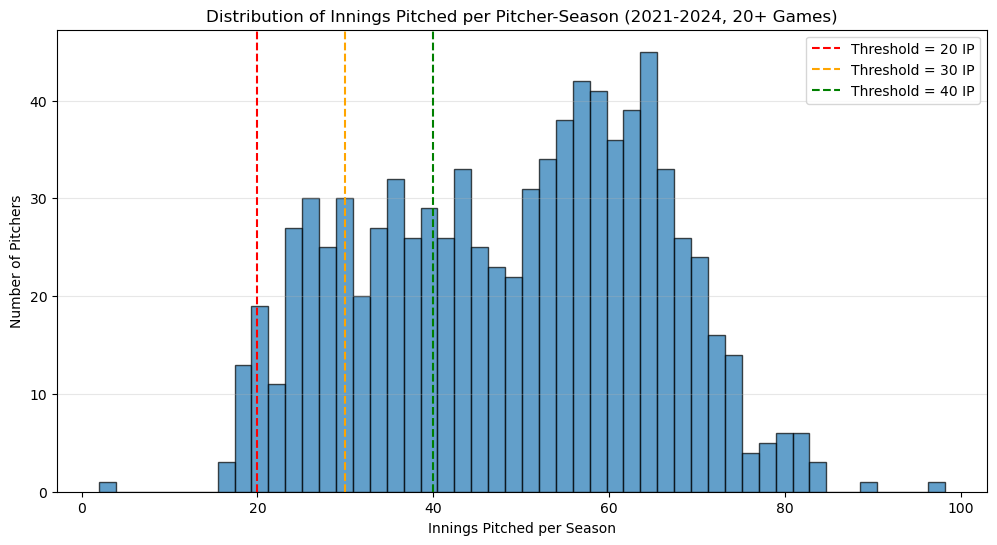

In [234]:
# Create histogram for innings pitched distribution
import matplotlib.pyplot as plt

ip_list = pitching_stats_filtered['IP'].to_list()

plt.figure(figsize=(12, 6))
plt.hist(ip_list, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Innings Pitched per Season')
plt.ylabel('Number of Pitchers')
plt.title('Distribution of Innings Pitched per Pitcher-Season (2021-2024, 20+ Games)')
plt.axvline(20, color='red', linestyle='--', label='Threshold = 20 IP')
plt.axvline(30, color='orange', linestyle='--', label='Threshold = 30 IP')
plt.axvline(40, color='green', linestyle='--', label='Threshold = 40 IP')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [235]:
# Count how many pitcher-seasons would be retained at different IP thresholds
ip_thresholds = [10, 15, 20, 25, 30, 35, 40, 45, 50]

for threshold in ip_thresholds:
    count = pitching_stats_filtered.filter(pl.col('IP') >= threshold).shape[0]
    total = pitching_stats_filtered.shape[0]
    pct = (count / total) * 100
    print(f"Threshold >= {threshold:2d} IP: {count:4d} pitcher-seasons ({pct:.1f}% retained)")

Threshold >= 10 IP:  866 pitcher-seasons (99.9% retained)
Threshold >= 15 IP:  866 pitcher-seasons (99.9% retained)
Threshold >= 20 IP:  850 pitcher-seasons (98.0% retained)
Threshold >= 25 IP:  796 pitcher-seasons (91.8% retained)
Threshold >= 30 IP:  720 pitcher-seasons (83.0% retained)
Threshold >= 35 IP:  661 pitcher-seasons (76.2% retained)
Threshold >= 40 IP:  587 pitcher-seasons (67.7% retained)
Threshold >= 45 IP:  515 pitcher-seasons (59.4% retained)
Threshold >= 50 IP:  448 pitcher-seasons (51.7% retained)


## I am going to use 30 IP as threshold

In [236]:
# Filter pitching_stats_filtered to pitchers with 30+ IP
pitchers_30plus_ip = pitching_stats_filtered.filter(pl.col('IP') >= 30).select(['Name', 'year'])

print(f"Pitcher-seasons with 30+ IP: {pitchers_30plus_ip.shape[0]}")

Pitcher-seasons with 30+ IP: 720


In [237]:
# Filter statcast_relievers_year_filtered to only include pitcher-years with 30+ IP
(final_summarized_reliever_table := statcast_relievers_year_filtered.join(
    pitchers_30plus_ip,
    left_on=['pitcher_name', 'year'],
    right_on=['Name', 'year'],
    how='inner'
))

print(f"Original shape: {statcast_relievers_year_filtered.shape}")
print(f"Final filtered shape: {final_summarized_reliever_table.shape}")
print(f"Pitches removed: {statcast_relievers_year_filtered.shape[0] - final_summarized_reliever_table.shape[0]}")
print(f"Unique pitchers: {final_summarized_reliever_table['pitcher_id'].n_unique()}")

Original shape: (856709, 35)
Final filtered shape: (647659, 35)
Pitches removed: 209050
Unique pitchers: 397


In [238]:
# Preview final dataset
final_summarized_reliever_table.head()

pitcher_id,date,game_id,velocity,spin_rate,pitch_type_abbr,pitch_type,pitch_result,ab_result,pitch_call,strike_zone,ball_count,strike_count,outs,inning,top_bottom,home_team,away_team,ab_number,pitch_num,batted_ball_type,runner_1b,runner_2b,runner_3b,away_score,home_score,defense_score,offense_score,game_type,batter_side,pitcher_hand,pitcher_days_since_prev_game,pitcher_days_until_next_game,year,pitcher_name
i64,datetime[ns],i64,f64,i64,str,str,str,str,str,i64,i64,i64,i64,i64,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,i32,str
433589,2021-04-01 00:00:00,634640,85.8,1989,"""FF""","""4-Seam Fastball""","""ball""",null,"""B""",11,0,0,2,6,"""Top""","""ATH""","""HOU""",41,1,null,null,670541,null,3,0,0,3,"""R""","""R""","""R""",null,3,2021,"""Yusmeiro Petit"""
433589,2021-04-01 00:00:00,634640,87.5,2182,"""FF""","""4-Seam Fastball""","""ball""",null,"""B""",12,0,0,1,6,"""Top""","""ATH""","""HOU""",39,1,null,663656,608324,null,1,0,0,1,"""R""","""R""","""R""",null,3,2021,"""Yusmeiro Petit"""
433589,2021-04-01 00:00:00,634640,85.6,2136,"""FF""","""4-Seam Fastball""","""ball""",null,"""B""",11,0,0,2,6,"""Top""","""ATH""","""HOU""",40,1,null,663656,608324,null,1,0,0,1,"""R""","""L""","""R""",null,3,2021,"""Yusmeiro Petit"""
433589,2021-04-01 00:00:00,634640,72.4,1772,"""CU""","""Curveball""","""called_strike""",null,"""S""",5,1,0,2,6,"""Top""","""ATH""","""HOU""",41,2,null,null,670541,null,3,0,0,3,"""R""","""R""","""R""",null,3,2021,"""Yusmeiro Petit"""
433589,2021-04-01 00:00:00,634640,87.2,2153,"""FF""","""4-Seam Fastball""","""ball""",null,"""B""",14,1,0,1,6,"""Top""","""ATH""","""HOU""",39,2,null,663656,608324,null,1,0,0,1,"""R""","""R""","""R""",null,3,2021,"""Yusmeiro Petit"""


In [245]:
# Save the final filtered relief pitcher dataset as a parquet file
final_summarized_reliever_table.write_parquet('data/statcast_relievers_final.parquet')

print(f"Saved {final_summarized_reliever_table.shape[0]} rows to data/statcast_relievers_final.parquet")

Saved 647659 rows to data/statcast_relievers_final.parquet


## Analyzing Final Dataset: Appearances by Year

Let's check how many relief appearances we have per year and assess if it's sufficient for analysis.

In [240]:
# Count unique pitcher-game combinations (appearances) by year
appearances_by_year = (final_summarized_reliever_table
    .group_by(['year', 'pitcher_id', 'game_id'])
    .agg(pl.len().alias('pitches'))
    .group_by('year')
    .agg([
        pl.len().alias('total_appearances'),
        pl.col('pitcher_id').n_unique().alias('unique_pitchers')
    ])
    .sort('year')
)

appearances_by_year

year,total_appearances,unique_pitchers
i32,u32,u32
2021,9910,190
2022,9300,179
2023,8791,167
2024,9860,184


In [241]:
# Get overall statistics
total_stats = (final_summarized_reliever_table
    .select([
        pl.col('pitcher_id').n_unique().alias('total_unique_pitchers'),
        pl.col('game_id').n_unique().alias('total_unique_games'),
        pl.len().alias('total_pitches')
    ])
)

# Count total appearances across all years
total_appearances = (final_summarized_reliever_table
    .group_by(['pitcher_id', 'game_id'])
    .agg(pl.len())
    .shape[0]
)

print(f"Total appearances across 2021-2024: {total_appearances}")
total_stats

Total appearances across 2021-2024: 37861


total_unique_pitchers,total_unique_games,total_pitches
u32,u32,u32
397,9515,647659


In [242]:
# Calculate average appearances per pitcher per year
avg_appearances = (final_summarized_reliever_table
    .group_by(['year', 'pitcher_id', 'game_id'])
    .agg(pl.len())
    .group_by(['year', 'pitcher_id'])
    .agg(pl.len().alias('appearances_per_pitcher'))
    .group_by('year')
    .agg([
        pl.col('appearances_per_pitcher').mean().alias('avg_appearances'),
        pl.col('appearances_per_pitcher').median().alias('median_appearances'),
        pl.col('appearances_per_pitcher').min().alias('min_appearances'),
        pl.col('appearances_per_pitcher').max().alias('max_appearances')
    ])
    .sort('year')
)

avg_appearances

year,avg_appearances,median_appearances,min_appearances,max_appearances
i32,f64,f64,u32,u32
2021,52.157895,54.5,22,81
2022,51.955307,55.0,22,77
2023,52.640719,56.0,20,78
2024,53.586957,56.0,20,78


---

# Final Dataset Summary

## Dataset Characteristics

**File:** `data/statcast_relievers_final.parquet`  
**Time Period:** 2021-2024 MLB seasons  
**Granularity:** Pitch-level data

In [ ]:
# Generate comprehensive summary statistics for the FINAL dataset
print("=" * 80)
print("FINAL RELIEF PITCHER DATASET SUMMARY")
print("=" * 80)

# Overall metrics from final_summarized_reliever_table
total_pitches = final_summarized_reliever_table.shape[0]
unique_pitchers = final_summarized_reliever_table['pitcher_id'].n_unique()
unique_games = final_summarized_reliever_table['game_id'].n_unique()

# Count total appearances
total_appearances = (final_summarized_reliever_table
    .group_by(['pitcher_id', 'game_id'])
    .agg(pl.len())
    .shape[0]
)

print(f"\n📊 OVERALL METRICS")
print(f"   Total Pitches:        {total_pitches:>10,}")
print(f"   Unique Pitchers:      {unique_pitchers:>10,}")
print(f"   Unique Games:         {unique_games:>10,}")
print(f"   Total Appearances:    {total_appearances:>10,}")
print(f"   Avg Pitches/App:      {total_pitches/total_appearances:>10.1f}")

# Year breakdown
print(f"\n📅 BREAKDOWN BY YEAR")
year_summary = (final_summarized_reliever_table
    .group_by('year')
    .agg([
        pl.len().alias('pitches'),
        pl.col('pitcher_id').n_unique().alias('pitchers'),
        pl.col('game_id').n_unique().alias('games')
    ])
    .sort('year')
)

for row in year_summary.iter_rows(named=True):
    print(f"   {row['year']}: {row['pitches']:>8,} pitches | {row['pitchers']:>3} pitchers | {row['games']:>5,} games")

# Filtering criteria impact
print(f"\n🔍 FILTERING CRITERIA APPLIED")
print(f"   ✓ Relief pitchers only (< 3 starts per season)")
print(f"   ✓ Minimum 20 games pitched per season")
print(f"   ✓ Minimum 30 innings pitched per season")

# Calculate retention rate from original combined dataset
original_size = statcast_combined.shape[0]
retention_rate = (total_pitches / original_size) * 100

print(f"\n📉 DATA REDUCTION")
print(f"   Original Dataset:     {original_size:>10,} pitches")
print(f"   Final Dataset:        {total_pitches:>10,} pitches")
print(f"   Retention Rate:       {retention_rate:>10.1f}%")

# Pitcher activity distribution
pitcher_appearances = (final_summarized_reliever_table
    .group_by(['year', 'pitcher_id'])
    .agg(pl.col('game_id').n_unique().alias('appearances'))
    .select('appearances')
)

print(f"\n🎯 PITCHER ACTIVITY DISTRIBUTION (Appearances per Season)")
print(f"   Minimum:              {pitcher_appearances['appearances'].min():>10}")
print(f"   25th Percentile:      {pitcher_appearances['appearances'].quantile(0.25):>10.0f}")
print(f"   Median:               {pitcher_appearances['appearances'].median():>10.0f}")
print(f"   75th Percentile:      {pitcher_appearances['appearances'].quantile(0.75):>10.0f}")
print(f"   Maximum:              {pitcher_appearances['appearances'].max():>10}")
print(f"   Mean:                 {pitcher_appearances['appearances'].mean():>10.1f}")

# Key variables available
print(f"\n📋 KEY VARIABLES (31 columns)")
print(f"   • Pitcher ID & Name")
print(f"   • Date, Game ID, Year")
print(f"   • Velocity, Spin Rate, Pitch Type")
print(f"   • Pitch Outcomes (result, call, AB result)")
print(f"   • Game Context (inning, outs, count, score)")
print(f"   • Baserunners, Batter/Pitcher Handedness")
print(f"   • Rest Days (since previous game, until next game)")

print(f"\n✅ Dataset ready for rest day analysis")
print(f"💾 Saved to: data/statcast_relievers_final.parquet")
print("=" * 80)

FINAL RELIEF PITCHER DATASET SUMMARY

📊 OVERALL METRICS
   Total Pitches:           647,659
   Unique Pitchers:             397
   Unique Games:              9,515
   Total Appearances:        37,861
   Avg Pitches/App:            17.1

📅 BREAKDOWN BY YEAR
   2021:  168,774 pitches | 190 pitchers | 2,380 games
   2022:  159,915 pitches | 179 pitchers | 2,391 games
   2023:  150,069 pitches | 167 pitchers | 2,351 games
   2024:  168,901 pitches | 184 pitchers | 2,393 games

🔍 FILTERING CRITERIA APPLIED
   ✓ Relief pitchers only (< 3 starts per season)
   ✓ Minimum 20 games pitched per season
   ✓ Minimum 30 innings pitched per season

📉 DATA REDUCTION
   Original Dataset:      2,853,845 pitches
   Final Dataset:           647,659 pitches
   Retention Rate:             22.7%

🎯 PITCHER ACTIVITY DISTRIBUTION (Appearances per Season)
   Minimum:                      20
   25th Percentile:              41
   Median:                       55
   75th Percentile:              64
   Maximum:   

## Quality Checks

In [244]:
# Perform data quality checks
print("=" * 80)
print("DATA QUALITY CHECKS")
print("=" * 80)

# Check for null values in critical columns
critical_columns = ['pitcher_id', 'date', 'game_id', 'velocity', 'spin_rate', 'pitch_type']

print(f"\n🔍 NULL VALUE CHECK (Critical Columns)")
for col in critical_columns:
    null_count = final_summarized_reliever_table[col].null_count()
    null_pct = (null_count / total_pitches) * 100
    status = "✓" if null_count == 0 else "⚠"
    print(f"   {status} {col:20s}: {null_count:>8,} nulls ({null_pct:>5.2f}%)")

# Check date range
date_range = final_summarized_reliever_table.select([
    pl.col('date').min().alias('first_date'),
    pl.col('date').max().alias('last_date')
])

print(f"\n📆 DATE RANGE")
print(f"   First Pitch: {date_range['first_date'][0]}")
print(f"   Last Pitch:  {date_range['last_date'][0]}")

# Check for duplicate rows
duplicate_check = final_summarized_reliever_table.shape[0]
unique_check = final_summarized_reliever_table.unique().shape[0]

print(f"\n🔄 DUPLICATE CHECK")
if duplicate_check == unique_check:
    print(f"   ✓ No duplicate rows found")
else:
    print(f"   ⚠ {duplicate_check - unique_check:,} duplicate rows detected")

# Verify pitcher names are present
unnamed_pitchers = final_summarized_reliever_table['pitcher_name'].null_count()

print(f"\n👤 PITCHER NAME LOOKUP")
if unnamed_pitchers == 0:
    print(f"   ✓ All {unique_pitchers:,} pitchers have names")
else:
    print(f"   ⚠ {unnamed_pitchers:,} pitches missing pitcher names")

print("\n" + "=" * 80)

DATA QUALITY CHECKS

🔍 NULL VALUE CHECK (Critical Columns)
   ✓ pitcher_id          :        0 nulls ( 0.00%)
   ✓ date                :        0 nulls ( 0.00%)
   ✓ game_id             :        0 nulls ( 0.00%)
   ⚠ velocity            :    4,356 nulls ( 0.67%)
   ⚠ spin_rate           :    7,436 nulls ( 1.15%)
   ⚠ pitch_type          :    4,421 nulls ( 0.68%)

📆 DATE RANGE
   First Pitch: 2021-04-01 00:00:00
   Last Pitch:  2024-09-29 00:00:00

🔄 DUPLICATE CHECK
   ✓ No duplicate rows found

👤 PITCHER NAME LOOKUP
   ✓ All 397 pitchers have names



## Next Steps

This dataset (`statcast_relievers_final.parquet`) is now ready for the next phase of analysis:

1. **Calculate Rest Days** ([data_managing_summary_stats_capstone.ipynb](data_managing_summary_stats_capstone.ipynb))
   - Compute days of rest between appearances for each pitcher
   - Aggregate pitch-level data to game-level statistics
   - Create variables like average velocity, spin rate, and control metrics per appearance

2. **Exploratory Analysis**
   - Visualize relationship between rest days and performance metrics
   - Identify optimal rest periods for different pitcher types
   - Examine trends across seasons

3. **Statistical Modeling**
   - Build regression models to quantify rest day effects
   - Control for confounding variables (opponent strength, game situation)
   - Test hypotheses about velocity decline and recovery patterns

The filtered dataset ensures we're analyzing pitchers with consistent, substantial usage patterns while excluding position players, spot starters, and rarely-used relievers.